## 02 Support Vector Machines
- From Udacity's Intro To Machine Learning class
- SupportVectorMachine is an algorithm that will separate points
- The SVM will try and maximise the distance/margin between the classes, while tolerating outliers
- For this notebook we will use the same Driving Terrain dataset (Grade, Bumpiness, Speed) as for 01_NaiveBayes

### 1. Import Terrain data and create graph function

In [1]:
import pandas as pd
import numpy as np

In [2]:
## Import the Prep Terrain Data from the last exercise

import random


def makeTerrainData(n_points=1000):
###############################################################################
### make the toy dataset
    random.seed(42)
    grade = [random.random() for ii in range(0,n_points)]
    bumpy = [random.random() for ii in range(0,n_points)]
    error = [random.random() for ii in range(0,n_points)]
    y = [round(grade[ii]*bumpy[ii]+0.3+0.1*error[ii]) for ii in range(0,n_points)]
    for ii in range(0, len(y)):
        if grade[ii]>0.8 or bumpy[ii]>0.8:
            y[ii] = 1.0

### split into train/test sets
    X = [[gg, ss] for gg, ss in zip(grade, bumpy)]
    split = int(0.75*n_points)
    X_train = X[0:split]
    X_test  = X[split:]
    y_train = y[0:split]
    y_test  = y[split:]

    grade_sig = [X_train[ii][0] for ii in range(0, len(X_train)) if y_train[ii]==0]
    bumpy_sig = [X_train[ii][1] for ii in range(0, len(X_train)) if y_train[ii]==0]
    grade_bkg = [X_train[ii][0] for ii in range(0, len(X_train)) if y_train[ii]==1]
    bumpy_bkg = [X_train[ii][1] for ii in range(0, len(X_train)) if y_train[ii]==1]

#    training_data = {"fast":{"grade":grade_sig, "bumpiness":bumpy_sig}
#            , "slow":{"grade":grade_bkg, "bumpiness":bumpy_bkg}}


    grade_sig = [X_test[ii][0] for ii in range(0, len(X_test)) if y_test[ii]==0]
    bumpy_sig = [X_test[ii][1] for ii in range(0, len(X_test)) if y_test[ii]==0]
    grade_bkg = [X_test[ii][0] for ii in range(0, len(X_test)) if y_test[ii]==1]
    bumpy_bkg = [X_test[ii][1] for ii in range(0, len(X_test)) if y_test[ii]==1]

    test_data = {"fast":{"grade":grade_sig, "bumpiness":bumpy_sig}
            , "slow":{"grade":grade_bkg, "bumpiness":bumpy_bkg}}

    return X_train, y_train, X_test, y_test
#    return training_data, test_data

In [3]:
## Create the pretty picture funciton again

import warnings
warnings.filterwarnings("ignore")

import matplotlib 
matplotlib.use('agg')

import matplotlib.pyplot as plt
import pylab as pl
import numpy as np
#import seaborn as SNS
%matplotlib inline

#import numpy as np
#import matplotlib.pyplot as plt
#plt.ioff()

def prettyPicture(clf, X_test, y_test):
    x_min = 0.0; x_max = 1.0
    y_min = 0.0; y_max = 1.0

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, m_max]x[y_min, y_max].
    h = .01  # step size in the mesh
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

    plt.pcolormesh(xx, yy, Z, cmap=pl.cm.seismic)

    # Plot also the test points
    grade_sig = [X_test[ii][0] for ii in range(0, len(X_test)) if y_test[ii]==0]
    bumpy_sig = [X_test[ii][1] for ii in range(0, len(X_test)) if y_test[ii]==0]
    grade_bkg = [X_test[ii][0] for ii in range(0, len(X_test)) if y_test[ii]==1]
    bumpy_bkg = [X_test[ii][1] for ii in range(0, len(X_test)) if y_test[ii]==1]

    plt.scatter(grade_sig, bumpy_sig, color = "b", label="fast")
    plt.scatter(grade_bkg, bumpy_bkg, color = "r", label="slow")
    plt.legend()
    plt.xlabel("bumpiness")
    plt.ylabel("grade")
    plt.show()
    #plt.savefig("test.png")
    
import base64
import json
import subprocess

def output_image(name, format, bytes):
    image_start = "BEGIN_IMAGE_f9825uweof8jw9fj4r8"
    image_end = "END_IMAGE_0238jfw08fjsiufhw8frs"
    data = {}
    data['name'] = name
    data['format'] = format
    data['bytes'] = base64.encodestring(bytes)
    print image_start+json.dumps(data)+image_end
    

### 2. SVM classification on a simple example dataset

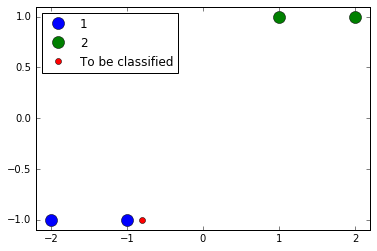

In [4]:
## Example SVC from sklearn website

X = np.array([[-1, -1], [-2, -1], [1, 1], [2, 1]])
Y = np.array([1, 1, 2, 2])


## Very handy list generation - including for loop in list

x_val = [x[0] for x in X]
y_val = [x[1] for x in X]

df = pd.DataFrame({
        'x_val': x_val,
        'y_val': y_val,
        'label': Y
    })

# Now group this dataframe into the different classes and look at some stats
groups = df.groupby('label')

# Plot
ax = plt.subplot()

ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in groups:
    ax.plot(group.x_val, group.y_val, marker='o', linestyle='', ms=12, label=name)

unknown_x=-0.8  
unknown_y=-1
ax.plot(unknown_x, unknown_y, 'or', label="To be classified")
ax.legend(loc="upper left", numpoints=1)
plt.show()

In [5]:
from sklearn.svm import SVC
clf = SVC()
clf.fit(X, Y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

print "Point (-0.8, -1) is predicted to be class %d" %(clf.predict([[-0.8, -1]]))

Point (-0.8, -1) is predicted to be class 1


### 3. Compare NB and SVM accuracy

In [6]:
def classify_SVC_linear(features_train, labels_train):   
    from sklearn.svm import SVC
    clf = SVC(kernel="linear")
    fit = clf.fit(features_train, labels_train) 
    return fit

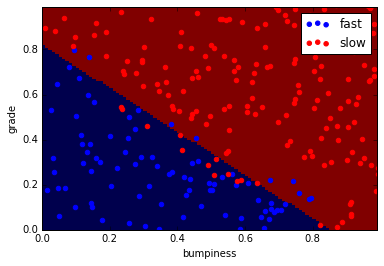

In [7]:
""" Complete the code in ClassifyNB.py with the sklearn
    Naive Bayes classifier to classify the terrain data.
    
    The objective of this exercise is to recreate the decision 
    boundary found in the lesson video, and make a plot that
    visually shows the decision boundary """

features_train, labels_train, features_test, labels_test = makeTerrainData()

### the training data (features_train, labels_train) have both "fast" and "slow" points mixed
### in together--separate them so we can give them different colors in the scatterplot,
### and visually identify them
grade_fast = [features_train[ii][0] for ii in range(0, len(features_train)) if labels_train[ii]==0]
bumpy_fast = [features_train[ii][1] for ii in range(0, len(features_train)) if labels_train[ii]==0]
grade_slow = [features_train[ii][0] for ii in range(0, len(features_train)) if labels_train[ii]==1]
bumpy_slow = [features_train[ii][1] for ii in range(0, len(features_train)) if labels_train[ii]==1]


# You will need to complete this function imported from the ClassifyNB script.
# Be sure to change to that code tab to complete this quiz.
clf_SVC_linear = classify_SVC_linear(features_train, labels_train)



### draw the decision boundary with the text points overlaid
prettyPicture(clf_SVC_linear, features_test, labels_test)
#output_image("test.png", "png", open("test.png", "rb").read())


In [8]:
pred = clf_SVC_linear.predict(features_test)

from sklearn.metrics import accuracy_score

print "NB accuracy was 88.4%"
print "SVM accruacy is %.1f%%" %(100*accuracy_score(pred, labels_test))

NB accuracy was 88.4%
SVM accruacy is 92.0%


### 4. Compare Kernal-DecisionBoundary relationship
- Notice in the above graph that we have a "straight" decision boundary as opposed to the curved decision boundary we got with Naive Bayes
- The above is a Linear SVM classifier could have been explicitly set using: SVC(kernel="linear")
- Lets compare an "rbf" classifier and see what our decision boundary looks like

In [9]:
def classify_SVC_rbf(features_train, labels_train):   
    from sklearn.svm import SVC
    clf = SVC(kernel="rbf")
    fit = clf.fit(features_train, labels_train) 
    return fit

In [10]:
# train classifier
clf_SVC_rbf = classify_SVC_rbf(features_train, labels_train)

# create predictions
pred_rbf = clf_SVC_rbf.predict(features_test)

# print accuracy
print "RBF SVM accuracy", accuracy_score(pred_rbf, labels_test)

RBF SVM accuracy 0.92


rbf kernel:



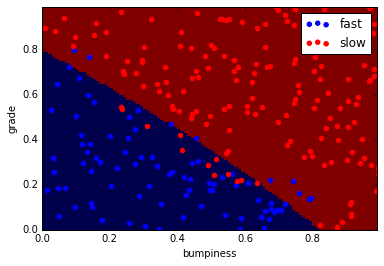



linear kernel:



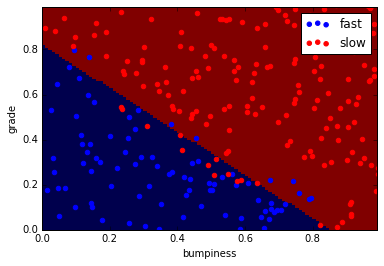

In [11]:
## Have a look at the decision boundary

print "rbf kernel:\n"
prettyPicture(clf_SVC_rbf, features_test, labels_test)

print "\n\nlinear kernel:\n"
prettyPicture(clf_SVC_linear, features_test, labels_test)

###  Now lets look at the "gamma" and "C" parameters
- Kernal - Specifies the kernal type to be used in the algorithm
- Gamma - Controls the Kernal coefficient
- C - Controls the tradeoff between a smooth decision boundary and classifying points correctly

In [12]:
def classify_SVC_rbf_gamma_C(features_train, labels_train, gamma, C):   
    from sklearn.svm import SVC
    clf = SVC(kernel="rbf", gamma=gamma, C=C)
    fit = clf.fit(features_train, labels_train)
    return fit

Original:



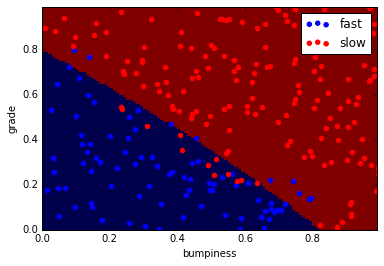



Gamma=1, C=1:



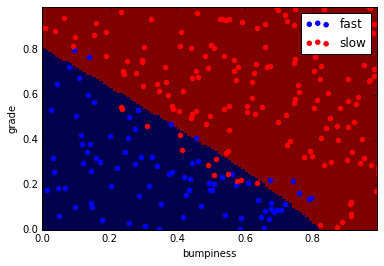



Gamma=1, C=1000:



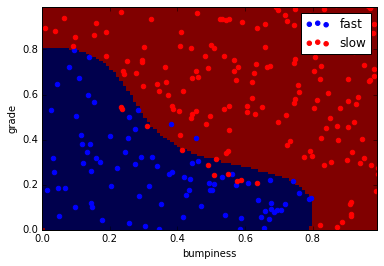



Gamma=1000, C=1:



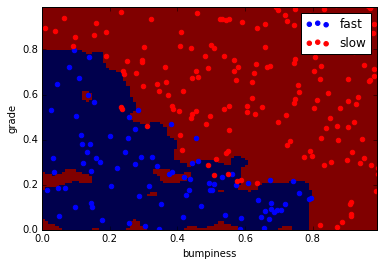



Gamma=1000, C=1000:



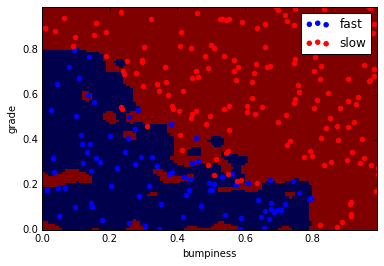

In [13]:
print "Original:\n"
prettyPicture(classify_SVC_rbf(features_train,labels_train), features_test, labels_test)

print "\n\nGamma=1, C=1:\n"
prettyPicture(classify_SVC_rbf_gamma_C(features_train,labels_train,1,1), features_test, labels_test)

print "\n\nGamma=1, C=1000:\n"
prettyPicture(classify_SVC_rbf_gamma_C(features_train,labels_train,1,1000), features_test, labels_test)


print "\n\nGamma=1000, C=1:\n"
prettyPicture(classify_SVC_rbf_gamma_C(features_train,labels_train,1000,1), features_test, labels_test)


print "\n\nGamma=1000, C=1000:\n"
prettyPicture(classify_SVC_rbf_gamma_C(features_train,labels_train,1000,1000), features_test, labels_test)

#### Looking at the above:
- We can see some examples of over-fitting

### SVM Notes
- If x & y are not linearly seperable (Annulus example), then we can feature engineer (e.g. x2+y2) to create a feature space where SVM can create a linear separation (e.g. x & z, where z=(x2+y2)
- x,y not separable => kernal trick allows linear separation in a higher dimensional feature space (x1, x2, x3...) => reverse kernal trick allows non-linear separation in original x,y space

- Work well in complicated domains where there is a clear margin of separation
- Don't work well with large datasets as the training times are cubically related to dataset size
- Don't work well with noisy datasets - where a lot of overlapping between the classes (NB better in this case)
